# Laser Test

This notebook to be used to turn laser on for a couple hours every day and monitor the output from day to day with a photodiode. The photodiode is attached to a 2" illumination sphere.

In [1]:
from astropy.io import fits
import astropy.stats
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import csv
import glob
import asyncio
from datetime import datetime
import astropy.units as u
import pandas as pd
from scipy import interpolate

from lsst.ts import salobj
from lsst_efd_client import EfdClient, resample
from astropy.time import Time, TimeDelta

In [2]:
d = salobj.Domain()

In [3]:
data_dir = '/home/parfa30/DATA/Laser'

In [16]:
all_files = os.listdir(data_dir)
bad_files = glob.glob(data_dir+'/BAD_*')
files = []
for filen in all_files:
    if os.path.join(data_dir, filen) not in bad_files:
        files.append(filen)

In [17]:
bad_files

['/home/parfa30/DATA/Laser/BAD_laser_scan_120min_2022-09-20T19:59:46.481.csv',
 '/home/parfa30/DATA/Laser/BAD_laser_scan_60min_2022-09-16T22:05:47.csv',
 '/home/parfa30/DATA/Laser/BAD_laser_scan_120min_2022-09-19T22:40:48.csv']

In [18]:
files

['laser_scan_180min_2022-09-23T19:26:24.505.csv',
 'laser_scan_180min_2022-09-29T19:37:26.905.csv',
 'laser_scan_120min_2022-09-21T22:55:40.547.csv',
 'laser_scan_240min_2022-09-27T21:48:08.070.csv',
 'laser_scan_60min_2022-09-21T19:04:50.046.csv',
 'laser_scan_60min_2022-10-04T23:54:14.238.csv',
 'laser_scan_120min_2022-09-23T15:57:02.048.csv',
 'laser_scan_180min_2022-09-28T19:34:31.827.csv',
 'laser_scan_120min_2022-09-22T18:20:50.547.csv']

In [7]:
Equivalent to 0.53mJ; 0.525W in no SCU when I started all of this 2 weeks ago.m

SyntaxError: invalid decimal literal (2933201407.py, line 1)

In [19]:
notes = {#'laser_scan_60min_2022-09-21T19:04:50.046.csv': 'first 60 minute scan', 
         'laser_scan_120min_2022-09-21T22:55:40.547.csv': 'longer scan', 
         #'laser_scan_120min_2022-09-22T18:20:50.547.csv': 'started scan right after turning on laser but then got interrupted',
         #'laser_scan_120min_2022-09-23T15:57:02.048.csv':'after laser had been one for a little while, also interrupted. Actual date 9/22',
         'laser_scan_180min_2022-09-23T19:26:24.505.csv': 'laser had been on over night',
        'laser_scan_240min_2022-09-27T21:48:08.070.csv': 'laser had been off for several days, then on for about 5-10 minutes when data taking started',
        'laser_scan_180min_2022-09-28T19:34:31.827.csv':'temp 23.37 at turn on 24.76 at end, 0.4W; 0.4mJ',
        'laser_scan_180min_2022-09-29T19:37:26.905.csv': 'laser had been on. Have temp sensor running. one of the ports was open',
        'laser_scan_60min_2022-10-04T23:54:14.238.csv':'laser had been on over weekend'}

In [26]:
df = pd.read_csv(os.path.join(data_dir,'laser_scan_180min_2022-09-29T19:37:26.905.csv'))

In [27]:
df.iloc[0]['START']

'2022-09-29 16:37:15.152840+00:00'

In [28]:
df.iloc[-1]['STOP']

'2022-09-29 19:37:11.854799+00:00'

In [20]:
from collections import OrderedDict

In [21]:
notes = OrderedDict(notes)

## Get Data

In [22]:
wavel = 450

In [23]:
df = pd.read_csv('../hamamatsu_responsivity.csv')

f = interpolate.interp1d(list(df.wavelength), list(df.responsivity))
def watts_per_mm2(amps,wl):
    area = 10**2 #10mm^2
    watts = amps/f(wl)
    watts_per_mm2 = watts/area
    return watts_per_mm2

In [24]:
def get_all_current_values(df):
    current = []
    time_ = []
    for i, d in data.iterrows():
        try:
            filen = str(d['FILEN'])
            start, end = os.path.splitext(filen)[0].split('_')
            ff = os.path.join(dir_, filen)
            hdu = fits.open(ff)
            edata = fits.open(ff)[0].data
            values = edata[1]
            time_delta = edata[0]
            meas_time = [Time(t + float(start) - 37, scale='tai',format='unix_tai') for t in time_delta]
            times = [x.datetime64 for x in meas_time]
            current.append(values)
            time_.append(times)
        except:
            print(i)
            current.append(None)
            time_.append(None)
    return current, time_

In [25]:
from matplotlib.pyplot import cm
colors = cm.rainbow(np.linspace(0, 1, len(files)))

Measured output of  0.53mJ; 0.525W in no SCU on 9/16

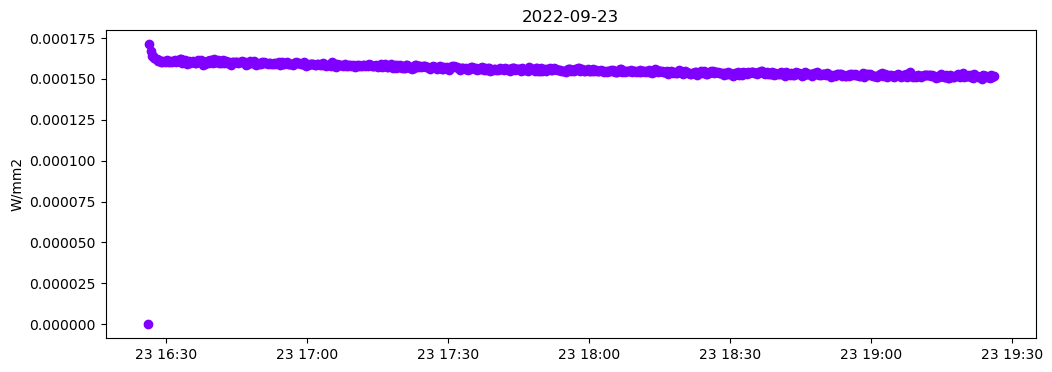

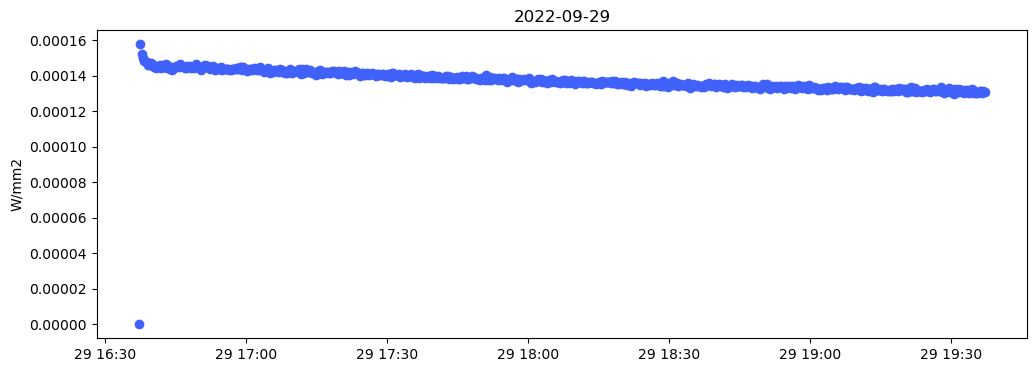

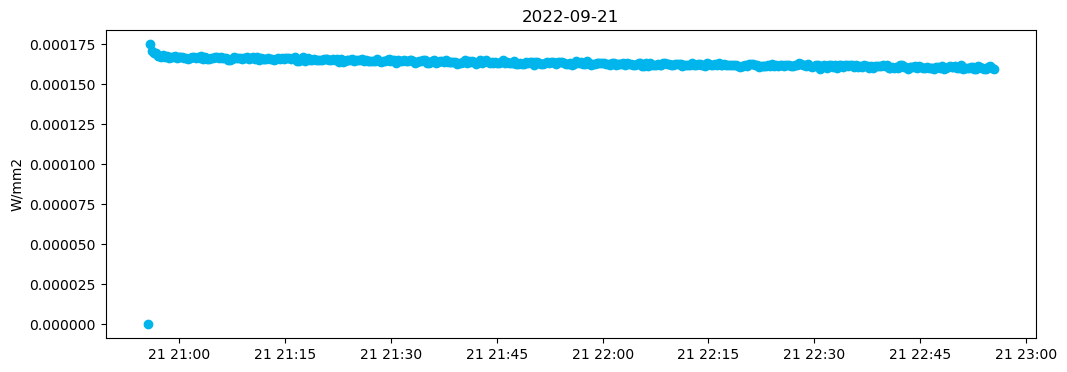

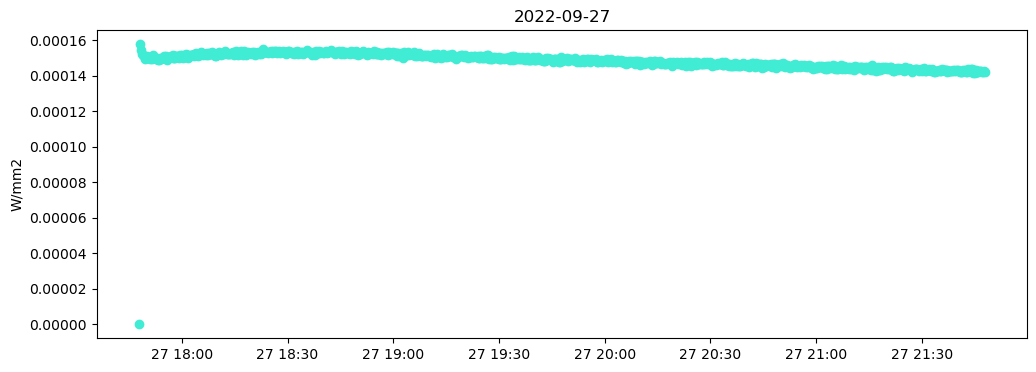

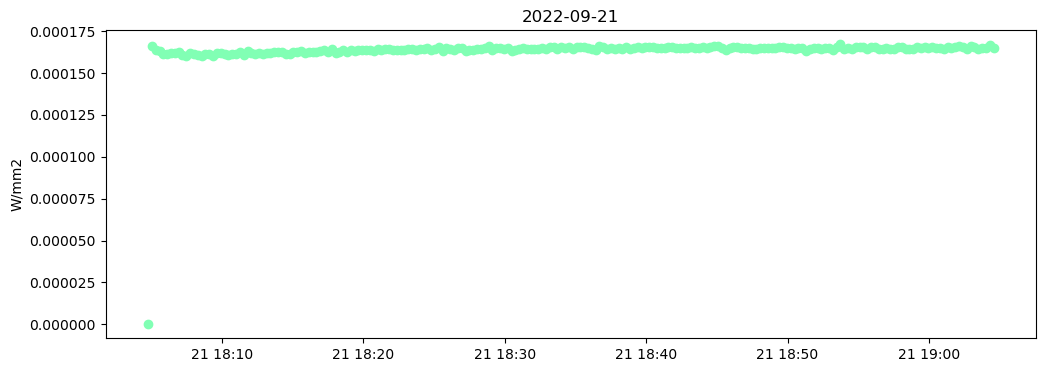

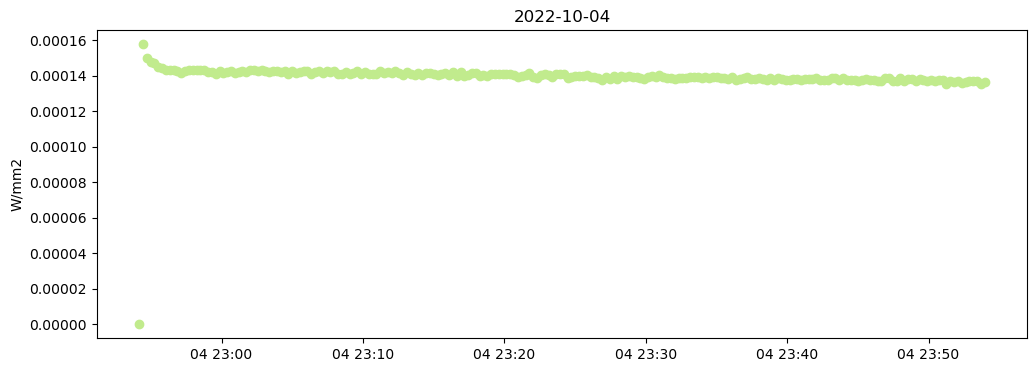

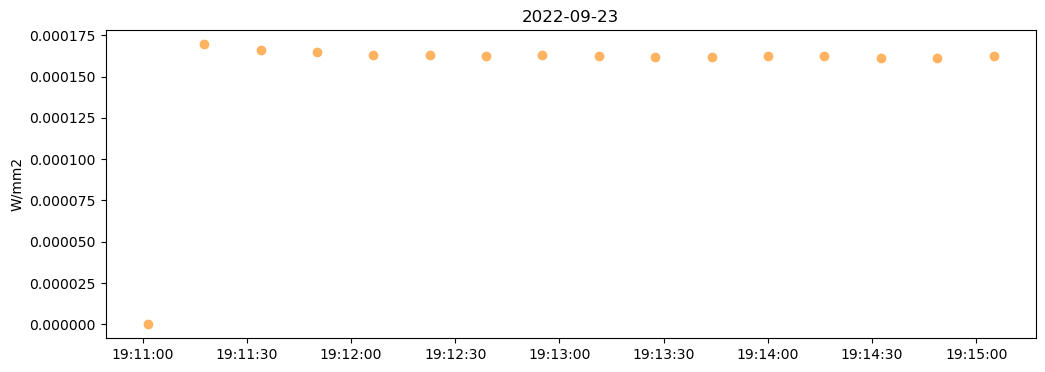

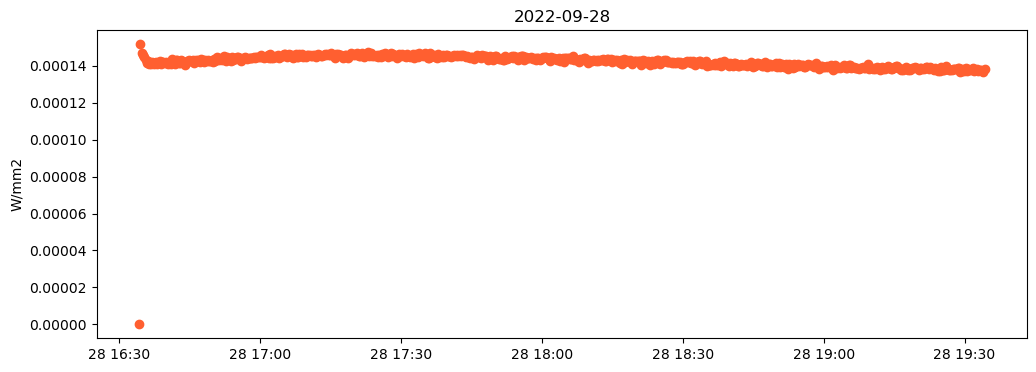

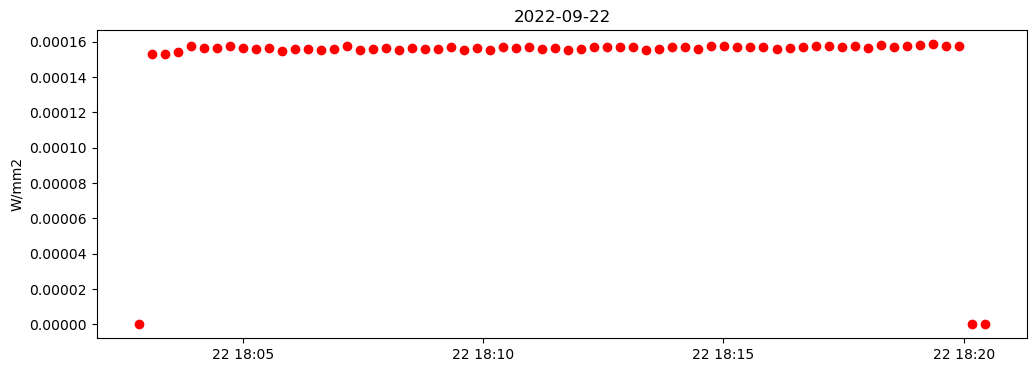

In [26]:
for i, filen in enumerate(files):
    plt.figure(figsize=(12,4))
    df = pd.read_csv(os.path.join(data_dir, filen))
    date = filen.split('_')[-1].split('T')[0]
    plt.scatter(pd.to_datetime(df.START), watts_per_mm2(df.MEAN*-1, wavel), color=colors[i])
    plt.title(date)
    plt.ylabel('W/mm2')

Text(0.5, 1.0, 'Laser output at No SCU taken with photodiode (@450nm)')

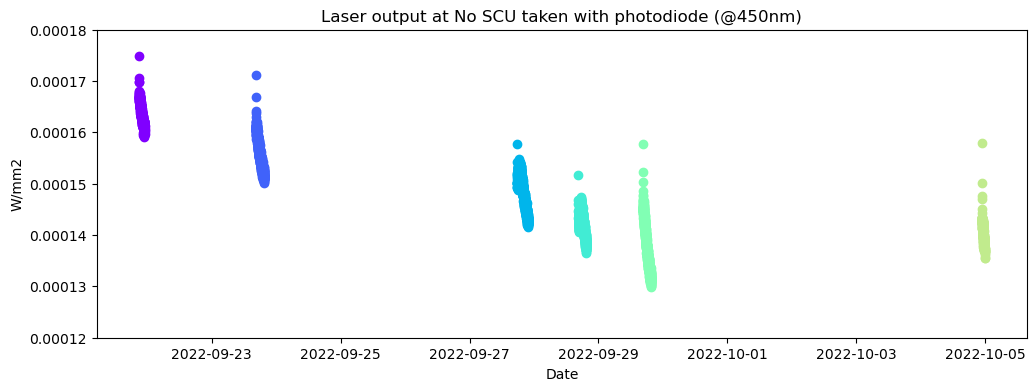

In [27]:
plt.figure(figsize=(12,4))
for i, filen in enumerate(notes.keys()):
    df = pd.read_csv(os.path.join(data_dir, filen))
    date = filen.split('_')[-1].split('T')[0]
    plt.scatter(pd.to_datetime(df.START), watts_per_mm2(df.MEAN*-1, wavel), color = colors[i], label=date)
plt.ylim(.00012, .00018)
#plt.legend()
plt.ylabel('W/mm2')
plt.xlabel('Date')
plt.title('Laser output at No SCU taken with photodiode (@450nm)')

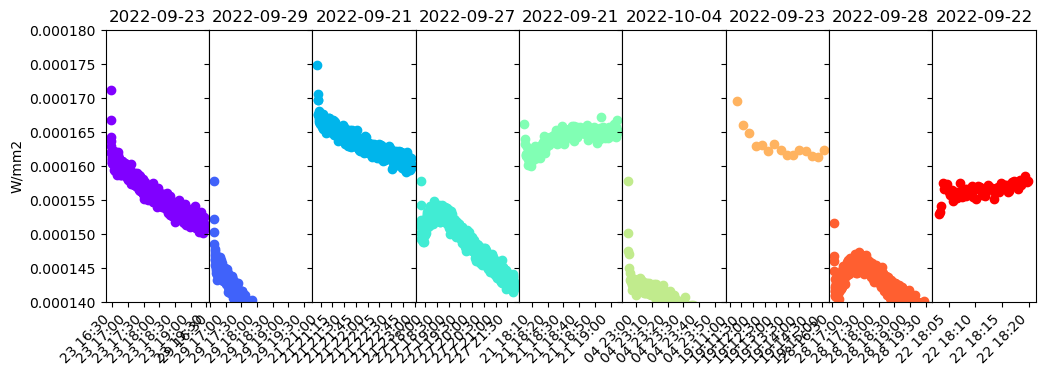

In [28]:
fig, axarr = plt.subplots(1, len(files), sharey=True, figsize=(12,4))
ax = axarr.ravel()

for i, filen in enumerate(files):
    df = pd.read_csv(os.path.join(data_dir, filen))
    date = filen.split('_')[-1].split('T')[0]
    ax[i].scatter(pd.to_datetime(df.START), watts_per_mm2(df.MEAN*-1, wavel), color=colors[i])
    ax[i].set_title(date)
    ax[i].set_ylim(0.000140, .00018)
    
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].set_ylabel('W/mm2')
fig.autofmt_xdate(rotation=45)

Text(0.5, 1.0, 'Stacked Laser Measurements at 450nm. 200 measurements ~ 1hr.')

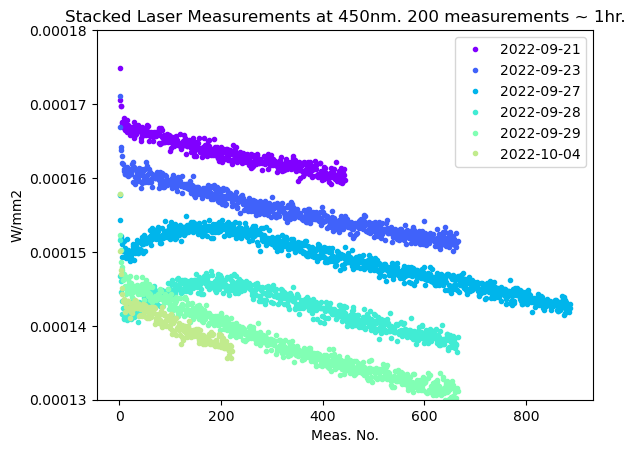

In [29]:
for i, filen in enumerate(notes.keys()):
    df = pd.read_csv(os.path.join(data_dir, filen))
    date = filen.split('_')[-1].split('T')[0]
    plt.plot(watts_per_mm2(df.MEAN*-1, wavel), '.',color=colors[i], label=date)
plt.legend()
plt.ylim(0.000130, .00018)
plt.ylabel('W/mm2')
plt.xlabel('Meas. No.')
plt.title('Stacked Laser Measurements at 450nm. 200 measurements ~ 1hr.')

2022-09-21: -1.26e-08 x + 1.66e-04
2022-09-23: -1.25e-08 x + 1.59e-04
2022-09-27: -1.55e-08 x + 1.56e-04
2022-09-28: -1.85e-08 x + 1.50e-04
2022-09-29: -1.85e-08 x + 1.43e-04
2022-10-04: -3.01e-08 x + 1.43e-04


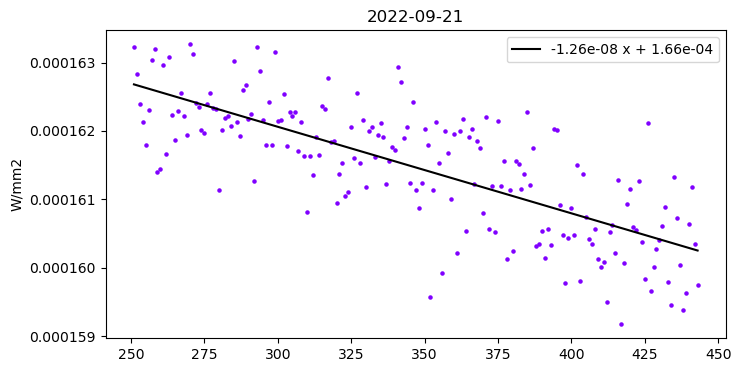

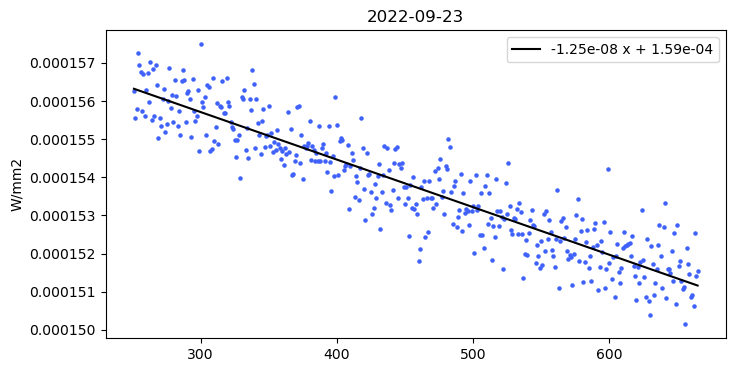

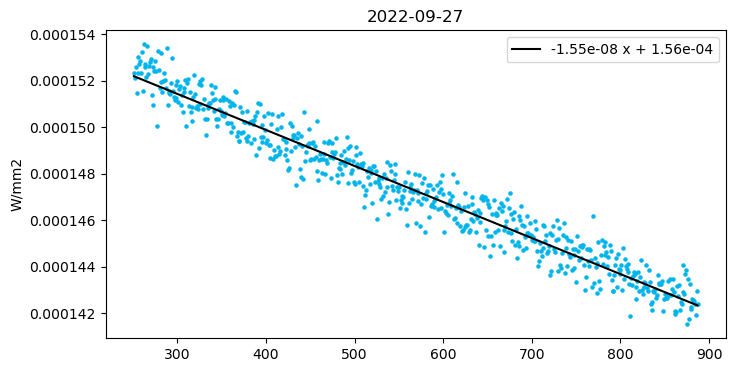

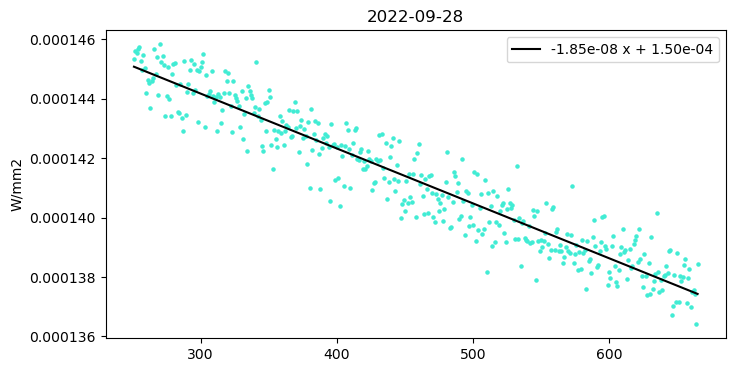

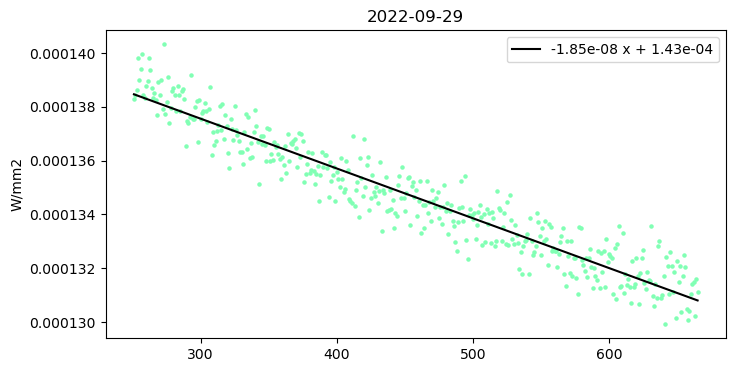

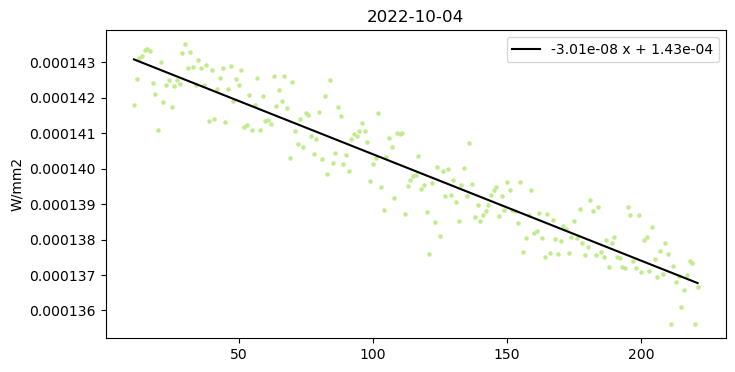

In [31]:
fits = []
for i, filen in enumerate(notes.keys()):
    df = pd.read_csv(os.path.join(data_dir, filen))
    date = filen.split('_')[-1].split('T')[0]
    x = np.array(df.index)
    if filen == 'laser_scan_60min_2022-10-04T23:54:14.238.csv':
        idx = np.where(x>10)
    else:
        idx = np.where(x>250)
    
    d = np.array(watts_per_mm2(df.MEAN*-1, wavel))
    d = d[idx]
    x = x[idx]
    plt.figure(figsize=(8,4))
    plt.scatter(x, d,color=colors[i],s=5)
    z = np.polyfit(x, d, 1)
    p = np.poly1d(z)
    fits.append(p)
    plt.plot(x, p(x), color='k',label='{:.2e} x + {:.2e}'.format(z[0], z[1]))
    plt.legend()
    plt.title(date)
    plt.ylabel("W/mm2")
    print('{}: {:.2e} x + {:.2e}'.format(date, z[0], z[1]))

Text(0.5, 1.0, 'Laser Output  @ 450nm (200 measurements ~ 1hr)')

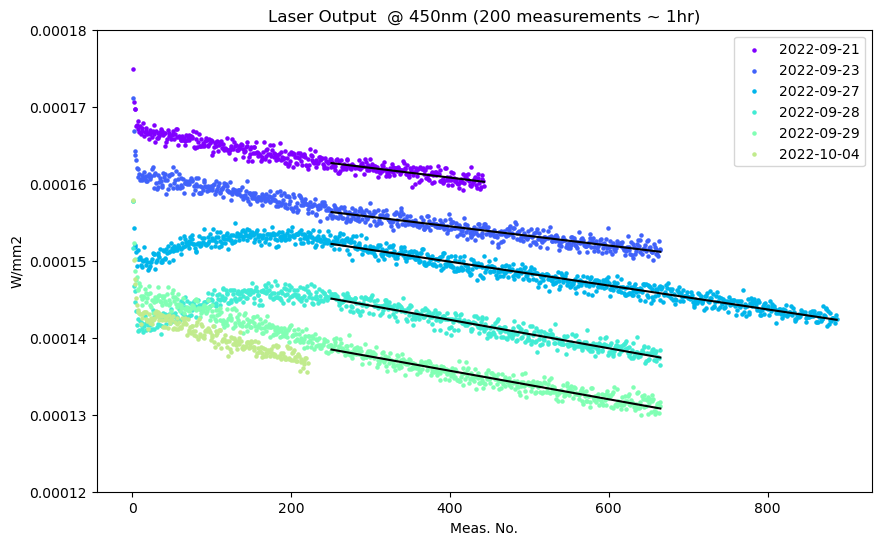

In [32]:
plt.figure(figsize=(10,6))
for i, filen in enumerate(notes.keys()):
    df = pd.read_csv(os.path.join(data_dir, filen))
    date = filen.split('_')[-1].split('T')[0]
    x = np.array(df.index)
    d = np.array(watts_per_mm2(df.MEAN*-1, wavel))
    plt.scatter(x, d, s=5,color=colors[i], label=date)
    idx = np.where(x>250)
    xx = x[idx]
    plt.plot(xx, fits[i](xx), c='k')
plt.legend()
plt.ylim(0.000120, .00018)
plt.ylabel('W/mm2')
plt.xlabel('Meas. No.')
plt.title('Laser Output  @ 450nm (200 measurements ~ 1hr)')